In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from mpmath import besseljzero
from scipy.special import gamma
from scipy.special import jv, iv, ive
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_HSDM_2D(a, mu, ndt, mu_alpha, sigma_alpha, sigma_z, sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    
    rt = 0
    
    while np.linalg.norm(x, 2) < a(rt):
        x += mu*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1, mu.shape)
        rt += dt
    
    theta = np.arctan2(x[1], x[0])   
    alpha = -np.abs(np.random.normal(mu_alpha, sigma_alpha))
    return ndt+rt, theta, alpha, np.random.normal(alpha + ndt, sigma_z)

In [3]:
def k(a, da, t, q, sigma=2):
    return 0.5 * (q - 0.5*sigma - da(t))

def psi(a, da, t, z, tau, q, sigma=2):
    kk = k(a, da, t, q, sigma)
    
    if 2*np.sqrt(a(t)*z)/(sigma*(t-tau))<=700:
        term1 = 1./(sigma*(t - tau)) * np.exp(- (a(t) + z)/(sigma*(t-tau)))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = iv(q/sigma-1, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * iv(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
    else:
        term1 = 1./(sigma*(t - tau))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = ive(q/sigma-1, (a(t) + z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * ive(q/sigma, (a(t) + z)/(sigma*(t-tau)))
    
    return term1 * term2 * (term3 * term4 + term5)

def ie_bessel_fpt(a, da, q, z, sigma=2, dt=0.1, T_max=2):
    g = [0]
    T = [0]
    g.append(-2*psi(a, da, dt, z, 0, q, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        s = -2 * psi(a, da, n*dt, z, 0, q, sigma)

        for j in range(1, n):
            if a(j*dt) == 0:
                continue
            
            s += 2 * dt * g[j] * psi(a, da, n*dt, a(j*dt), j*dt, q, sigma)

        g.append(s)
        T.append(n*dt)
        
    g = np.asarray(g)
    T = np.asarray(T)
    
    gt = interp1d(T, g)
    return gt

In [4]:
def HSDM_2D_likelihood(prms, RT, Theta, Z, Residual):
    a = lambda t: prms[0] * np.exp(-prms[1]*t)
    a2 = lambda t: (a(t))**2
    da2 = lambda t: -2 * prms[1]*prms[0]*np.exp(-prms[1]*t) * a(t)
    
    ndt = prms[2]
    mu = np.array([prms[3], prms[4]])
    sig_z = prms[5]
    alpha = prms[6]
    sig_alpha = prms[7]
    
    sig = np.sqrt(sig_z**2 + sig_alpha**2)
        
    T_max = max(RT)
    fpt = ie_bessel_fpt(a2, da2, mu.shape[0], 0.000001, 
                        dt=0.05, T_max=T_max)
        
    log_lik = 0
    for i in range(len(RT)):
        rt, theta = RT[i], Theta[i]
        if rt - ndt > 0.0001 and rt - ndt < T_max:
            mu_dot_x0 = mu[0]*np.cos(theta)
            mu_dot_x1 = mu[1]*np.sin(theta)
            term1 = a(rt - ndt) * (mu_dot_x0 + mu_dot_x1)
            term2 = 0.5 * np.linalg.norm(mu, 2)**2 * (rt - ndt)
            

            density = np.exp(term1 - term2) * fpt(rt - ndt)
            
            log_lik += 0.5*(Z[i] - ndt - alpha)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
            log_lik += 0.5*(Residual[i] - alpha)**2/sig_alpha**2 + 0.5*np.log(2*np.pi*sig_alpha**2)
            
            if 0.1**14 < density:
                log_lik += -np.log(density) 
            else:
                log_lik += -np.log(0.1**14) 
        else:
            log_lik += -np.log(0.1**14)
        
    return log_lik

In [5]:
recovery_dic = {'b0_true': [],
                'b0_estimate': [],
                'lambda_true': [],
                'lambda_estimate': [],
                'ndt_true': [],
                'ndt_estimate': [],
                'mu1_true': [],
                'mu1_estimate': [],
                'mu2_true': [],
                'mu2_estimate': [],
                'sigma_z_true':[],
                'sigma_z_estimate':[],
                'alpha_true': [],
                'alpha_estimate': [],
                'sigma_a_true': [],
                'sigma_a_estimate': []}

min_b0 = 2
max_b0 = 5

min_lambda = .1
max_lambda = 2

min_ndt = 0.1
max_ndt = 1

min_mu = -3
max_mu = 3

In [6]:
for n in tqdm(range(100)):
    b0 = np.random.uniform(min_b0, max_b0)
    lamb = np.random.uniform(min_lambda, max_lambda)
    a = lambda t: b0 * np.exp(-lamb*t)
    
    ndt = np.random.uniform(min_ndt, max_ndt)
    mu = np.array([np.random.uniform(min_mu, max_mu), 
                   np.random.uniform(min_mu, max_mu)])
    
    sigma_z = np.random.uniform(0.05, 0.2)
    sigma_a = np.random.uniform(0.05, 0.2)
    mu_alpha = np.random.uniform(-2.5, -1.5)
    
    RT = []
    Theta = []
    Z = []
    Residual = []
    
    for i in range(500):
        rt, theta, alpha, z = simulate_HSDM_2D(a, mu, ndt, mu_alpha, sigma_a, sigma_z)
        RT.append(rt)
        Theta.append(theta)
        Z.append(z)
        Residual.append(alpha)
    
    min_ans = differential_evolution(HSDM_2D_likelihood,
                                     args=(RT, Theta, Z, Residual),
                                     bounds=[(min_b0, max_b0), (min_lambda, max_lambda), 
                                             (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu),
                                             (0.05, 0.2), (-2.5, -1.5), (0.05, 0.2)])
    
    min_ans = minimize(HSDM_2D_likelihood,
                       args=(RT, Theta, Z, Residual),
                       method='nelder-mead',
                       x0=min_ans.x,
                       bounds=[(min_b0, max_b0), (min_lambda, max_lambda),
                               (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu),
                               (0.05, 0.2), (-2.5, -1.5), (0.05, 0.2)])
    
    if min_ans.success:
        recovery_dic['b0_true'].append(b0)
        recovery_dic['lambda_true'].append(lamb)
        recovery_dic['ndt_true'].append(ndt)
        recovery_dic['mu1_true'].append(mu[0])
        recovery_dic['mu2_true'].append(mu[1])
        recovery_dic['sigma_z_true'].append(sigma_z)
        recovery_dic['alpha_true'].append(mu_alpha)
        recovery_dic['sigma_a_true'].append(sigma_a)

        recovery_dic['b0_estimate'].append(min_ans.x[0])
        recovery_dic['lambda_estimate'].append(min_ans.x[1])
        recovery_dic['ndt_estimate'].append(min_ans.x[2])
        recovery_dic['mu1_estimate'].append(min_ans.x[3])
        recovery_dic['mu2_estimate'].append(min_ans.x[4])
        recovery_dic['sigma_z_estimate'].append(min_ans.x[5])
        recovery_dic['alpha_estimate'].append(min_ans.x[6])
        recovery_dic['sigma_a_estimate'].append(min_ans.x[7])

100%|████████████████████████████████████| 100/100 [3:27:28<00:00, 124.49s/it]


In [7]:
recovery_df = pd.DataFrame(recovery_dic)

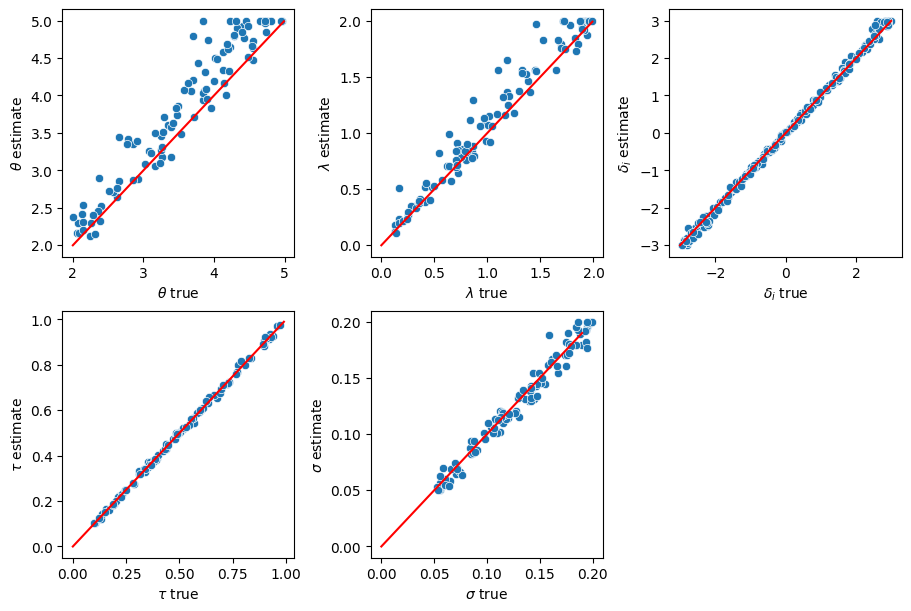

In [8]:
plt.figure(figsize=(9, 6), layout='constrained')

plt.subplot(231)
plt.plot(np.arange(2, 5, 0.01), np.arange(2, 5, 0.01), c='red')
sns.scatterplot(x='b0_true', y='b0_estimate', data=recovery_df);
plt.xlabel(r'$\theta$ true')
plt.ylabel(r'$\theta$ estimate')

plt.subplot(232)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='lambda_true', y='lambda_estimate', data=recovery_df);
plt.xlabel(r'$\lambda$ true')
plt.ylabel(r'$\lambda$ estimate')

plt.subplot(233)
plt.plot(np.arange(-3, 3, 0.01), np.arange(-3, 3, 0.01), c='red')
sns.scatterplot(x='mu1_true', y='mu1_estimate', data=recovery_df);
sns.scatterplot(x='mu2_true', y='mu2_estimate', data=recovery_df, c='tab:blue');
plt.xlabel(r'$\delta_i$ true')
plt.ylabel(r'$\delta_i$ estimate')

plt.subplot(234)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df);
plt.xlabel(r'$\tau$ true')
plt.ylabel(r'$\tau$ estimate');

plt.subplot(235)
plt.plot(np.arange(0, .2, 0.01), np.arange(0, .2, 0.01), c='red')
sns.scatterplot(x='sigma_z_true', y='sigma_z_estimate', data=recovery_df);
plt.xlabel(r'$\sigma$ true')
plt.ylabel(r'$\sigma$ estimate');

In [9]:
print(recovery_df.shape)
recovery_df.corr()

(100, 16)


,b0_true,b0_estimate,lambda_true,lambda_estimate,ndt_true,ndt_estimate,mu1_true,mu1_estimate,mu2_true,mu2_estimate,sigma_z_true,sigma_z_estimate,alpha_true,alpha_estimate,sigma_a_true,sigma_a_estimate
b0_true,1.000000,0.959828,0.164648,0.127334,-0.172538,-0.168656,0.063209,0.057661,0.079072,0.080929,-0.020951,-0.029552,-0.010455,-0.011682,0.072028,0.076030
b0_estimate,0.959828,1.000000,0.213554,0.222654,-0.150489,-0.148712,0.072247,0.070176,0.071071,0.072011,0.017860,0.009652,0.027978,0.027493,0.106885,0.110756
lambda_true,0.164648,0.213554,1.000000,0.977590,0.027867,0.035666,0.079612,0.083707,-0.090493,-0.088586,0.207755,0.236417,0.017994,0.019419,-0.026217,-0.012279
lambda_estimate,0.127334,0.222654,0.977590,1.000000,0.036959,0.044134,0.072666,0.079537,-0.073734,-0.071743,0.220710,0.242538,0.035181,0.036700,-0.001453,0.010932
ndt_true,-0.172538,-0.150489,0.027867,0.036959,1.000000,0.999315,-0.076757,-0.067247,-0.006495,-0.004355,0.129890,0.138332,-0.170231,-0.172572,0.040941,0.037556
ndt_estimate,-0.168656,-0.148712,0.035666,0.044134,0.999315,1.000000,-0.073432,-0.063963,-0.002305,0.000145,0.134078,0.142319,-0.169104,-0.171740,0.044322,0.041471
mu1_true,0.063209,0.072247,0.079612,0.072666,-0.076757,-0.073432,1.000000,0.998964,0.018302,0.027252,-0.018290,-0.009608,-0.149836,-0.150857,-0.009865,-0.005321
mu1_estimate,0.057661,0.070176,0.083707,0.079537,-0.067247,-0.063963,0.998964,1.000000,0.024330,0.033656,-0.012039,-0.002092,-0.149074,-0.150063,-0.009006,-0.004708
mu2_true,0.079072,0.071071,-0.090493,-0.073734,-0.006495,-0.002305,0.018302,0.024330,1.000000,0.998937,-0.130962,-0.144548,-0.104008,-0.104187,-0.060659,-0.058179
mu2_estimate,0.080929,0.072011,-0.088586,-0.071743,-0.004355,0.000145,0.027252,0.033656,0.998937,1.000000,-0.134417,-0.148622,-0.102677,-0.102975,-0.069493,-0.066721


In [10]:
recovery_df.to_csv('Exponential_rec.csv')